In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [14]:
# Expanded hyperparameters for RandomForest
hyperparameters = {
    'n_estimators': [100, 150],  # Number of trees in the forest
    'max_depth': [6, 8],    # Maximum depth of the tree, 'None' means no limit
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt','log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]       # Whether bootstrap samples are used when building trees
}


In [15]:
### --- Functions

# Load and process datasets
def pf_LoadClean(filepath):
    """Load and preprocess the dataset."""
    # Load data
    df = pd.read_csv(filepath)

    # Remove groups with 5 or fewer instances
    group_counts = df['Group'].value_counts()
    df = df[df['Group'].isin(group_counts[group_counts > 5].index)]

    # Encode categorical variables
    df = pd.get_dummies(df, columns=ML_CATEGORICAL)

    # Label Encoding for the target variable
    label_encoder = LabelEncoder()
    df['Group'] = label_encoder.fit_transform(df['Group'])

    return df, label_encoder


def pf_TrainModel(df, target_variable, hyperparameters):
    # Drop rows with NaN values
    df = df.dropna()

    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Upsampling
    ros = RandomOverSampler(random_state=123)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # Initialize RandomForest classifier
    model = RandomForestClassifier()

    # Grid search for hyperparameter tuning
    clf = GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5)
    clf.fit(X_train_resampled, y_train_resampled)

    return clf, X_test, y_test

# Function to plot feature importance for RandomForest
def pf_Plot_FeatureImportance(clf):
    """Plot feature importance of the model."""
    feature_importance = clf.best_estimator_.feature_importances_
    sorted_idx = feature_importance.argsort()
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.xlabel("Random Forest Feature Importance")
    plt.show()

def pf_EvaluateModel(clf, X_test, y_test, group_encoder):
    predictions = clf.predict(X_test)

    # Convert numeric predictions back to original labels
    original_labels = group_encoder.inverse_transform(predictions)

    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy:.2f}")

    return accuracy, original_labels

In [16]:
# Categorical Variables
ML_CATEGORICAL = ["geocode", "the_west", "event_type", "is_claimed", "suicide", "targets", "weapons", 
"intensity", "conflict", "admin_ID"]

TRAINING_DATA = "../../../02_data/processed/ml_testtraining.csv"

In [17]:
# Load and preprocess data
df_evaluate, group_encoder = pf_LoadClean(TRAINING_DATA)

In [20]:
# Train the model
clf, X_test, y_test = pf_TrainModel(df_evaluate, 'Group', hyperparameters)

In [21]:
# Evaluate the model and get original labels of predictions
accuracy, original_labels = pf_EvaluateModel(clf, X_test, y_test, group_encoder)

# Print original labels of predictions
print("Original Labels of Predictions:", original_labels)

Model Accuracy: 0.55
Original Labels of Predictions: ['Shia militia (undefined)' 'Abu Sayyaf'
 'Islamic State West Africa (ISWA)' ... 'Wrath of Olives'
 'Auto Defensas (AUC)' 'Anti-junta armed group (undetermined)']


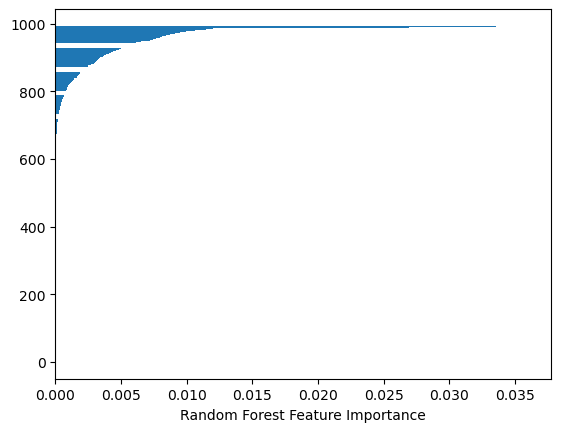

In [22]:
# Plot feature importance
pf_Plot_FeatureImportance(clf)

In [24]:
def pf_PredictNewData(filepath, clf, group_encoder):
    # Preprocess new data
    df_new, _ = pf_LoadClean(filepath)  # No need for the label encoder here
    X_new = df_new.drop('Group', axis=1)  # Assuming 'Group' is the target variable

    # Predict using the trained model
    predictions_new = clf.predict(X_new)

    # Convert numeric predictions back to original labels
    original_labels_new = group_encoder.inverse_transform(predictions_new)

    return original_labels_new

In [25]:
# Filepath for the new data
NEW_DATA = "../../../02_data/processed/ml_final.csv"



In [26]:
predicted_labels = pf_PredictNewData(NEW_DATA, clf, group_encoder)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- admin_ID_ALB.12_1
- admin_ID_ALB.9_1
- admin_ID_ARM.7_1
- admin_ID_AUS.5_1
- admin_ID_BDI.10_1
- ...
Feature names seen at fit time, yet now missing:
- admin_ID_AGO.4_1
- admin_ID_AGO.6_1
- admin_ID_ARG.4_1
- admin_ID_ARG.6_1
- admin_ID_AUS.10_1
- ...
